<a href="https://colab.research.google.com/github/KwonHo-geun/automobile/blob/main/25.07.21_SegmentationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

In [2]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [3]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [38]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

#Encoder - timm : 경량화되어있다./backbone
ENCODER = "timm-efficientnet-b0"    ### ✍️ 실습 코드 작성
WEIGHTS = 'imagenet'    ### ✍️ 실습 코드 작성


In [ ]:
df = pd.read_csv(CSV_FILE)    ### ✍️ 실습 코드 작성
df.head()

In [8]:
row = df.iloc[4]

image_path = row.images    ### ✍️ 실습 코드 작성
mask_path =  row.masks   ### ✍️ 실습 코드 작성

image = cv2.imread(image_path)   ### ✍️ 실습 코드 작성
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    ### ✍️ 실습 코드 작성

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)    ### ✍️ 실습 코드 작성

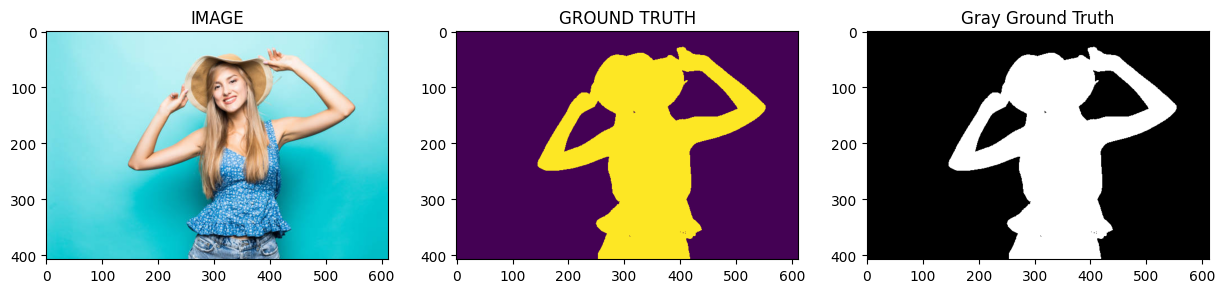

In [9]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)

ax3.set_title('Gray Ground Truth')
ax3.imshow(mask, cmap = 'gray')

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state= 42)    ### ✍️ 실습 코드 작성

In [12]:
import albumentations as A

In [17]:
def get_train_augs():
      ### ✍️ 실습 코드 작성
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
    #image, masks가 맞게 해야하기에 check하기 위해 작성(:자동으로 함)
    ], is_check_shapes=False)    ### ✍️ 실습 코드 작성

def get_valid_augs():
      ### ✍️ 실습 코드 작성
  return A.Compose([
      #검증에선 랜덤이 나와선 안된다. 랜덤 변형을 피해야한다.
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
    #image, masks가 맞게 해야하기에 check하기 위해 작성(:자동으로 함)
    ], is_check_shapes=False)    ### ✍️ 실습 코드 작성

In [15]:
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
  #csv, True
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)    ### ✍️ 실습 코드 작성
    #Shape을 동일하게 3000으로 고정
    #albumentation호환을 위해 (H, W, 1)로 함
    mask = np.expand_dims(mask, axis = -1)    ### ✍️ 실습 코드 작성

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)    ### ✍️ 실습 코드 작성
      image = data['image']    ### ✍️ 실습 코드 작성
      mask = data['mask']    ### ✍️ 실습 코드 작성

    #원래는 (h, w, c)로->pytorch는 (c, h, w)로 변환해야함.

    image = np.transpose(image, (2,0,1)).astype(np.float32)    ### ✍️ 실습 코드 작성
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)    ### ✍️ 실습 코드 작성

    image = torch.Tensor(image) / 255.0   ### ✍️ 실습 코드 작성
    #Grayscale로 해서 Round로 0 or 1로 해줘야함
    mask = torch.round(torch.Tensor(mask) / 255.0)    ### ✍️ 실습 코드 작성

    return image, mask

In [18]:
trainset = SegmentationDataset(train_df, get_train_augs())    ### ✍️ 실습 코드 작성
validset = SegmentationDataset(valid_df, get_valid_augs())    ### ✍️ 실습 코드 작성

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

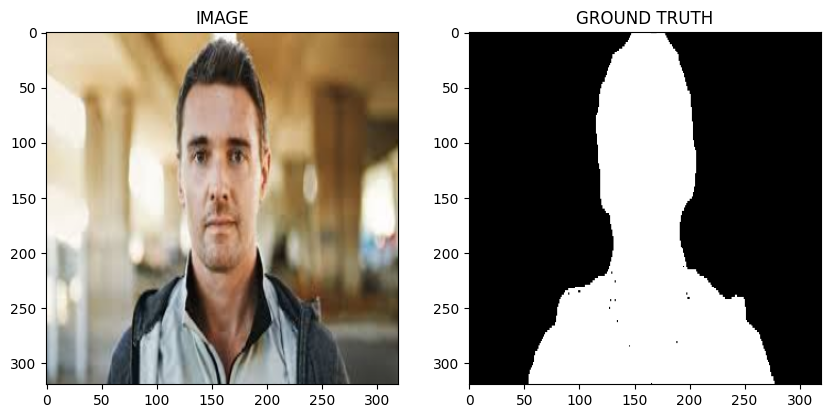

In [20]:
idx = 32

image, mask = trainset[idx]
# trainset[1]
helper.show_image(image, mask)

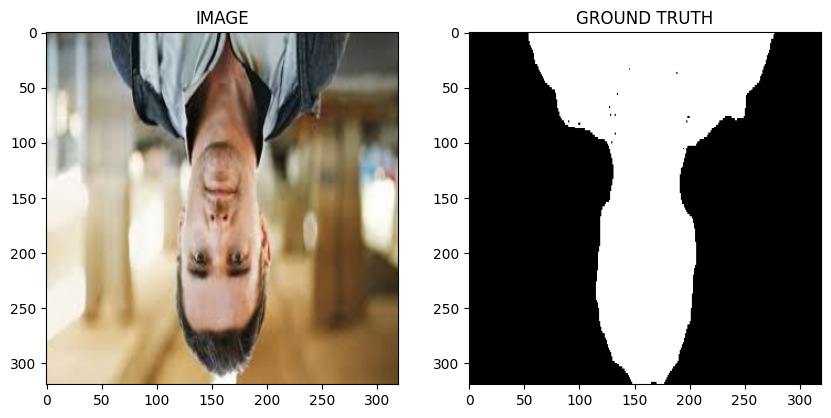

In [22]:
#50%의 확률로 반대로 됨.
idx = 32

image, mask = trainset[idx]
# trainset[1]
helper.show_image(image, mask)

In [23]:
from torch.utils.data import DataLoader

In [24]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)    ### ✍️ 실습 코드 작성
#평가할 땐 랜덤을 하지 않는다.
validloader = DataLoader(validset, batch_size = BATCH_SIZE)    ### ✍️ 실습 코드 작성

In [25]:
print(f"total no. of batches in trainloader : {len(trainloader)}") #232/16 = 15
print(f"total no. of batches in validloader : {len(validloader)}") #58/16 = 3.625 = 4

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [26]:
#**데이터 Shape가 제대로 되었는지 확인
for image, mask in trainloader:
  break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}') #training

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


In [27]:
from torch import nn
import segmentation_models_pytorch as smp
#DiceLoss는 픽셀간 겹침 비율을 최적화시킴
from segmentation_models_pytorch.losses import DiceLoss

In [28]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,    ### ✍️ 실습 코드 작성
        encoder_weights = WEIGHTS,    ### ✍️ 실습 코드 작성
        in_channels = 3,
        classes = 1,
        #출력 => loss로 정의
        activation = None
    )

  def forward(self, images, masks=None):
    #smp로 정의한 Unet의 output(행)
    logits = self.arc(images)

    #Segmentation 품질 + 안정적인 학습 BCEW => sigmod + binary cross entropy
    if masks != None:
      #Mast 겹침
      loss1 = DiceLoss(mode ='binary')(logits, masks)    ### ✍️ 실습 코드 작성
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)    ### ✍️ 실습 코드 작성
      #0.7loss1 + 0.3loss2
      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()   ### ✍️ 실습 코드 작성
model.to(DEVICE)

In [40]:
def train_fn(data_loader, model, optimizer):


    ### ✍️ 실습 코드 작성
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)     ### ✍️ 실습 코드 작성


In [41]:
def eval_fn(data_loader, model):


    ### ✍️ 실습 코드 작성
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()


  return total_loss/len(data_loader)     ### ✍️ 실습 코드 작성

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)   ### ✍️ 실습 코드 작성

In [45]:
best_valid_loss = np.inf    ### ✍️ 실습 코드 작성

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)    ### ✍️ 실습 코드 작성
  valid_loss = eval_fn(validloader, model)    ### ✍️ 실습 코드 작성

  if valid_loss < best_valid_loss  :    ### ✍️ 실습 코드 작성
        ### ✍️ 실습 코드 작성
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED_MODEL")
    best_valid_loss = valid_loss    ### ✍️ 실습 코드 작성

  print(f'Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}')


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


SAVED_MODEL
Epoch : 1 Train_loss : 0.7010090351104736 Valid_loss : 0.6069067269563675


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


SAVED_MODEL
Epoch : 2 Train_loss : 0.43007906476656593 Valid_loss : 0.3554867319762707


100%|██████████| 4/4 [00:00<00:00,  6.42it/s]


SAVED_MODEL
Epoch : 3 Train_loss : 0.3317776848872503 Valid_loss : 0.3194850757718086


100%|██████████| 4/4 [00:00<00:00,  6.18it/s]


SAVED_MODEL
Epoch : 4 Train_loss : 0.29233456949392955 Valid_loss : 0.26678215712308884


100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


SAVED_MODEL
Epoch : 5 Train_loss : 0.2201467712720235 Valid_loss : 0.24601943418383598


100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


Epoch : 6 Train_loss : 0.23644818464914957 Valid_loss : 0.2687855437397957


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


SAVED_MODEL
Epoch : 7 Train_loss : 0.21891014873981476 Valid_loss : 0.23189692199230194


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


SAVED_MODEL
Epoch : 8 Train_loss : 0.18433607518672943 Valid_loss : 0.22752755880355835


100%|██████████| 4/4 [00:00<00:00,  6.22it/s]


SAVED_MODEL
Epoch : 9 Train_loss : 0.1744820882876714 Valid_loss : 0.2084775734692812


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


SAVED_MODEL
Epoch : 10 Train_loss : 0.16857865552107493 Valid_loss : 0.18844829127192497


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch : 11 Train_loss : 0.158169990281264 Valid_loss : 0.23575792461633682


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Epoch : 12 Train_loss : 0.14353850533564885 Valid_loss : 0.2122630812227726


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


Epoch : 13 Train_loss : 0.13778088241815567 Valid_loss : 0.22927124425768852


100%|██████████| 4/4 [00:00<00:00,  6.24it/s]


Epoch : 14 Train_loss : 0.16321150263150533 Valid_loss : 0.24654989317059517


100%|██████████| 4/4 [00:00<00:00,  6.32it/s]


Epoch : 15 Train_loss : 0.18507861644029616 Valid_loss : 0.22478856891393661


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch : 16 Train_loss : 0.2150573641061783 Valid_loss : 0.25435981899499893


100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


Epoch : 17 Train_loss : 0.17626215517520905 Valid_loss : 0.21332335472106934


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


SAVED_MODEL
Epoch : 18 Train_loss : 0.1640500401457151 Valid_loss : 0.17539836466312408


100%|██████████| 4/4 [00:00<00:00,  6.17it/s]


Epoch : 19 Train_loss : 0.1309070681532224 Valid_loss : 0.20636669546365738


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


Epoch : 20 Train_loss : 0.12495078146457672 Valid_loss : 0.21760302782058716


100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


Epoch : 21 Train_loss : 0.09705960005521774 Valid_loss : 0.23036259040236473


100%|██████████| 4/4 [00:00<00:00,  6.32it/s]


Epoch : 22 Train_loss : 0.10151929060618083 Valid_loss : 0.20480426773428917


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch : 23 Train_loss : 0.11908621763189634 Valid_loss : 0.20878567174077034


100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


Epoch : 24 Train_loss : 0.1352136105298996 Valid_loss : 0.2661249712109566


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

Epoch : 25 Train_loss : 0.12890033821264904 Valid_loss : 0.19581090286374092


In [47]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))    ### ✍️ 실습 코드 작성

image, mask = validset[idx]    ### ✍️ 실습 코드 작성

#배치차원 추가를 위해 unsqueeze로 함
logits_mask = model(image.to(DEVICE).unsqueeze(0))  #(C, H, W) -> (1, C, H, W)    ### ✍️ 실습 코드 작성
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

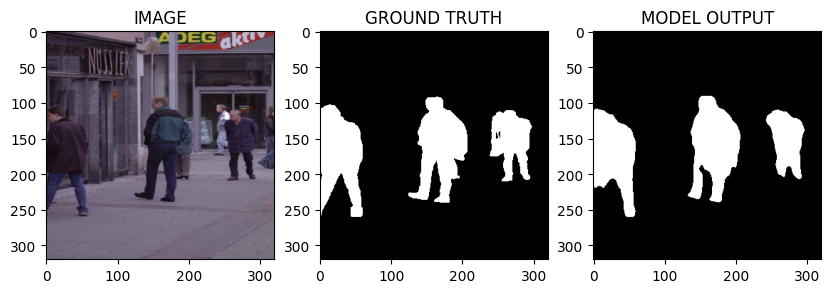

In [48]:
#1, 3, 320, 320 = > 3, 320, 320
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))    ### ✍️ 실습 코드 작성